In [1]:
import tensorflow as tf

In [2]:
import numpy

In [3]:
numpy.version.version

'1.15.4'

In [4]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))
from collections import defaultdict
import time
from PIL import Image

Using TensorFlow backend.


In [5]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *
from keras import optimizers
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [6]:
import os
import numpy as np
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from skimage.io import imread
import cv2 as cv
from skimage.transform import resize
%matplotlib inline

In [7]:
import skimage
print(skimage.__version__)

0.13.1


In [8]:
def get_model():
    inputs = Input((100, 100, 3), dtype='float32')
    
    x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(16, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 30,30
    
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 15,15
    
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = MaxPool2D((2,2))(x) # 8,8
    
#     x = Conv2D(256, 3, activation="relu", padding="same")(x)
#     x = Conv2D(128, 3, activation="relu", padding="same")(x)
#     x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(128, 3, activation="relu", padding="same")(x)
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = MaxPool2D((2,2))(x) # 8,8
    
    x = Conv2D(64, 3, activation="relu", padding="same")(x)
    x = Conv2D(32, 3, activation="relu", padding="same")(x)
    x = Flatten()(x)
    
    x = Dropout(0.2)(x)
    x = Dense(40, activation="tanh")(x)
    x = Dropout(0.2)(x)
    x = Dense(64)(x)
    
    base_model = Model(inputs=inputs, outputs = x)
    return base_model

In [9]:
import pandas as pd

In [10]:
df = pd.read_csv('characters.csv')

In [11]:
df.head()

,characters
0,\n Will ...
1,\n Rickard Karstark ...
2,\n Syrio Forel ...
3,\n Kraznys mo Nakloz ...
4,\n Lyanna Stark ...


In [12]:
charLst = [x.strip() for x in df.characters.values]

In [13]:
charLst[:5]

['Will',
 'Rickard Karstark',
 'Syrio Forel',
 'Kraznys mo Nakloz',
 'Lyanna Stark']

In [14]:
PATH = 'dataset/'

In [15]:
dirs = sorted(os.listdir(PATH))

#class name to id class
name_to_classid = {d:i for i,d in enumerate(dirs)}
#class id to class name
classid_to_name = {v:k for k,v in name_to_classid.items()}
num_classes = len(name_to_classid)
print("number of classes: " + str(num_classes))

number of classes: 96


In [16]:
# all images per class id
img_paths = {c:[PATH + directory + "/" + img
            for img in sorted(os.listdir(PATH+directory)[:(len(os.listdir(PATH+directory))/2)])] 
             for directory,c in name_to_classid.items()}
# print ({k:img_paths[k] for i, k in enumerate(img_paths) if i < 1})

In [17]:
# retrieve all images
all_images_path = []
for img_list in img_paths.values():
    all_images_path += img_list
    
# print (all_images_path[:5])

# image path to class id 
path_to_id = {v:k for k,v in enumerate(all_images_path)}
# class id to image path
id_to_path = {v:k for k,v in path_to_id.items()}

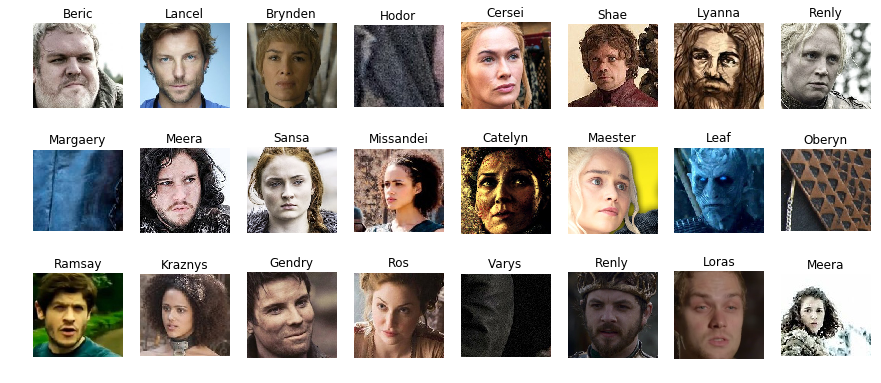

In [18]:
cols = 8
rows = 3
#pour allouer un cadre
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(all_images_path))
        #on place chacune des images sur le cadre
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(imread(all_images_path[random_index]))
        ax.set_title(all_images_path[random_index].split(os.path.sep)[1])
plt.show()

In [19]:
print (len(all_images_path))

1538


In [20]:
print (all_images_path[:5])

['dataset/Alliser/100.jpg', 'dataset/Alliser/102.jpg', 'dataset/Alliser/106.jpg', 'dataset/Alliser/108.jpg', 'dataset/Alliser/114.jpg']


In [21]:
# class id to image id
classid_to_ids = {k:[path_to_id[path] for path in v] for k,v in img_paths.items()}
# image id to class id
id_to_classid = {v:c for c,imgs in classid_to_ids.items() for v in imgs}
# print ({k:classid_to_ids[k] for i, k in enumerate(classid_to_ids) if i < 1})
# print ({k:id_to_classid[k] for i, k in enumerate(id_to_classid) if i < 10})

In [22]:
def build_pos_pairs_for_id(classid, max_num=50):
    imgs = classid_to_ids[classid]
    if len(imgs) == 1:
        return []
    pos_pairs = [(imgs[i], imgs[j]) for i in range(len(imgs)) for j in range(i+1,len(imgs))]
    random.shuffle(pos_pairs)
    return pos_pairs[:max_num]

In [23]:
def build_positive_pairs(class_id_range):
    listX1 = []
    listX2 = []
    
    for class_id in class_id_range:
        pos = build_pos_pairs_for_id(class_id, 100)
        for pair in pos:
            listX1 += [pair[0]]
            listX2 += [pair[1]]
    perm = np.random.permutation(len(listX1))
    return np.array(listX1)[perm], np.array(listX2)[perm]

In [24]:
split_num = int(num_classes * 0.8)

In [25]:
Xa_train, Xp_train = build_positive_pairs(range(0, split_num))
Xa_test, Xp_test = build_positive_pairs(range(split_num, num_classes-1))

# Gather the ids of all images that are used for train and test
all_img_train_idx = list(set(Xa_train) | set(Xp_train))
all_img_test_idx = list(set(Xa_test) | set(Xp_test))

In [26]:
print (len(Xa_test), len(Xp_test))

(1604, 1604)


In [27]:
Xa_train.shape, Xp_train.shape

((6823,), (6823,))

In [28]:
from imgaug import augmenters as iaa

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
])

In [29]:
# data generator which opens batch size images 
class TripletGenerator():
    def __init__(self, Xa_train, Xp_train, batch_size, all_imgs, neg_imgs_idx):
        self.cur_img_index=0
        self.cur_img_pos_index=0
        self.batch_size = batch_size
        
        self.imgs = all_imgs
        self.Xa = Xa_train
        self.Xp = Xp_train
        self.cur_train_index = 0
        self.num_samples = Xa_train.shape[0]
        self.neg_imgs_idx = neg_imgs_idx
    
    def augment(self, im_array):
        if np.random.uniform(0, 1) > 0.9:
            im_array = np.fliplr(im_array)
        return im_array

    # resize each image to 150 by 150px 
    def read_and_resize(self, filepath):
        img = imread(filepath)
        res = resize(img, (100, 100), preserve_range=True, mode='reflect')
        return np.expand_dims(res, 0)
    
    # open batch_size images 
    def next_train(self):
        while 1:
            self.cur_train_index += self.batch_size
            if self.cur_train_index >= self.num_samples:
                self.cur_train_index=0
            
            imgs_a = self.Xa[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_p = self.Xp[self.cur_train_index:self.cur_train_index+self.batch_size]
            imgs_n = random.sample(self.neg_imgs_idx,imgs_a.shape[0])
            
            lst_a = [self.imgs[x] for x in imgs_a]
            lst_p = [self.imgs[x] for x in imgs_p]
            lst_n = [self.imgs[x] for x in imgs_n]

            res_a = [self.read_and_resize(str(value)) for value in lst_a]
            res_a = np.vstack(res_a)
            
            res_p = [self.read_and_resize(str(value)) for value in lst_p]
            res_p = np.vstack(res_p)
            
            res_n = [self.read_and_resize(str(value)) for value in lst_n]
            res_n = np.vstack(res_n)
            
            a = [self.augment(value) for value in res_a]
            p = [self.augment(value) for value in res_p]
            n = [self.augment(value) for value in res_n]
            
            mean = np.mean(a, axis=(0,1,2))
            a -= mean
            mean = np.mean(p, axis=(0,1,2))
            p -= mean
            mean = np.mean(n, axis=(0,1,2))
            n -= mean

            yield ([a, p, n],
                    # placeholders for output, won't be needed 
                    np.zeros(shape=(imgs_a.shape[0]))
                    )

In [30]:
batch_size = 128
gen = TripletGenerator(Xa_train, Xp_train, batch_size, list(id_to_path.values()), all_img_train_idx)

In [31]:
import PIL
print(PIL.PILLOW_VERSION)

6.0.0


In [32]:
[xa, xp, xn], y = next(gen.next_train())

In [33]:
gen_test = TripletGenerator(Xa_test, Xp_test, batch_size, list(id_to_path.values()), all_img_test_idx)

In [34]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred - 0 * y_true)

# def identity_loss(y_true, y_pred, alpha = 0.2):
#     """
#     Implementation of the triplet loss as defined by formula (3)
    
#     Arguments:
#     y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
#     y_pred -- python list containing three objects:
#             anchor -- the encodings for the anchor images, of shape (None, 128)
#             positive -- the encodings for the positive images, of shape (None, 128)
#             negative -- the encodings for the negative images, of shape (None, 128)
    
#     Returns:
#     loss -- real number, value of the loss
#     """
    
#     anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
#     ### START CODE HERE ### (≈ 4 lines)
#     # Step 1: Compute the (encoding) distance between the anchor and the positive, you will need to sum over axis=-1
#     pos_dist = tf.reduce_sum(tf.square(tf.subtract(y_pred[0], y_pred[1])), axis=-1)
#     # Step 2: Compute the (encoding) distance between the anchor and the negative, you will need to sum over axis=-1
#     neg_dist = tf.reduce_sum(tf.square(tf.subtract(y_pred[0], y_pred[2])), axis=-1)
#     # Step 3: subtract the two previous distances and add alpha.
#     basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), alpha)
#     # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
#     loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
#     ### END CODE HERE ###
    
#     return loss

# The real loss is here
def cosine_triplet_loss(X):
    _alpha = 0.5
    positive_sim, negative_sim = X
    
    # batch loss
    losses = K.maximum(0.0, negative_sim - positive_sim + _alpha)
    
    return K.mean(losses)

In [35]:
shared_conv2 = get_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
anchor = Input((100, 100, 3), name='anchor')
positive = Input((100, 100, 3), name='positive')
negative = Input((100, 100, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

pos_sim = Dot(axes=-1, normalize=True)([a,p])
neg_sim = Dot(axes=-1, normalize=True)([a,n])

loss = Lambda(cosine_triplet_loss,
              output_shape=(1,))(
             [pos_sim,neg_sim])

model_triplet = Model(inputs=[anchor, positive, negative], outputs=loss)

model_triplet.compile(loss=identity_loss,
                      optimizer="rmsprop",
                      metrics = ['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


best_model_fname = "triplet.h5"
best_model_cb = ModelCheckpoint(best_model_fname, monitor='val_loss',
                                save_best_only=True, verbose=1)

In [38]:
print (Xa_train.shape[0])
print (batch_size)

6823
128


In [39]:
history = model_triplet.fit_generator(generator=gen.next_train(), 
                    steps_per_epoch=300, #300
                    epochs=1,
                    validation_data = gen_test.next_train(),
                    validation_steps=30,
                    callbacks=[best_model_cb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
 18/300 [>.............................] - ETA: 11:54 - loss: 0.5023 - acc: 0.5000

KeyboardInterrupt: 

In [ ]:
def euclidean(idx1,idx2):
    return np.linalg.norm(emb[idx1] - emb[idx2])

def cosine(idx1, idx2):
    return np.dot(emb[idx1], emb[idx2])

In [ ]:
def most_sim(x, emb, topn=5, mode="cosine"):
    if mode == "cosine":
        x = x / np.linalg.norm(x)
        sims = np.dot(emb, x)
        ids = np.argsort(sims)[::-1]
        return [(id,sims[id]) for id in ids[:topn]]
    else:
        dists = np.linalg.norm(emb - x, axis=-1)
        ids = np.argsort(dists)
        return [(id,dists[id]) for id in ids[:topn]]

In [ ]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [ ]:
test_ids = []
for class_id in range(split_num, num_classes-1):
    img_ids = classid_to_ids[class_id]
    if len(img_ids) > 1:
        test_ids += img_ids

In [ ]:
# to check your accuracy
def recall_k(k=10):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = [id_to_classid[x] for (x, score) in most_sim(emb[img_idx], emb, topn=k+1)[1:]]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)

In [ ]:
def random_recall_k(k=10):
    num_found = 0
    for img_idx in test_ids:
        image_class = id_to_classid[img_idx]
        found_classes = [id_to_classid[x] for x in random.sample(list(set(test_ids) - {img_idx}), k)]
        if image_class in found_classes:
            num_found += 1
    return num_found / len(test_ids)

In [ ]:
# Naive way to compute all similarities between all images. May be optimized!
def build_similarities(conv, all_imgs):
    embs = conv.predict(all_imgs)
    embs = embs / np.linalg.norm(embs, axis=-1, keepdims=True)
    all_sims = np.dot(embs, embs.T)
    return all_sims

def intersect(a, b):
    return list(set(a) & set(b))

def build_negatives(anc_idxs, pos_idxs, similarities, neg_imgs_idx, num_retries=20):
    # If no similarities were computed, return a random negative
    if similarities is None:
        return random.sample(neg_imgs_idx,len(anc_idxs))
    final_neg = []
    # for each positive pair
    for (anc_idx, pos_idx) in zip(anc_idxs, pos_idxs):
        anchor_class = id_to_classid[anc_idx]
        #positive similarity
        sim = similarities[anc_idx, pos_idx]
        # find all negatives which are semi(hard)
        possible_ids = np.where((similarities[anc_idx] + 0.25) > sim)[0]
        possible_ids = intersect(neg_imgs_idx, possible_ids)
        appended = False
        for iteration in range(num_retries):
            if len(possible_ids) == 0:
                break
            idx_neg = random.choice(possible_ids)
            if id_to_classid[idx_neg] != anchor_class:
                final_neg.append(idx_neg)
                appended = True
                break
        if not appended:
            final_neg.append(random.choice(neg_imgs_idx))
    return final_neg

In [ ]:
batch_size = 128

In [ ]:
print (len(Xa_train), len(Xp_train))

In [ ]:
gen_train = TripletGenerator(Xa_train, Xp_train, batch_size, list(id_to_path.values()), all_img_test_idx)

In [ ]:
shared_conv2 = get_model()

In [ ]:
anchor = Input((100, 100, 3), name='anchor')
positive = Input((100, 100, 3), name='positive')
negative = Input((100, 100, 3), name='negative')

a = shared_conv2(anchor)
p = shared_conv2(positive)
n = shared_conv2(negative)

pos_sim = Dot(axes=-1, normalize=True)([a,p])
neg_sim = Dot(axes=-1, normalize=True)([a,n])

loss = Lambda(cosine_triplet_loss,
              output_shape=(1,))(
             [pos_sim,neg_sim])

model_triplet = Model(
    inputs=[anchor, positive, negative],
    outputs=loss)

opt = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model_triplet.compile(loss=identity_loss, optimizer=opt, metrics=['accuracy'])

In [ ]:
gen_test = TripletGenerator(Xa_test, Xp_test, batch_size, list(id_to_path.values()), all_img_test_idx)

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [ ]:
filepath = 'model/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_acc',
                             verbose=1,
                             mode='max')

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=1,
                              verbose=1,
                              min_lr=0.001)

In [ ]:
earlystp = EarlyStopping(monitor='val_loss',
                         min_delta=1e-5,
                         patience=1,
                         verbose=1,
                         mode='auto')

In [ ]:
nb_epochs = 1
for epoch in range(nb_epochs):
    print("built new hard generator for epoch " + str(epoch))
    model_triplet.fit_generator(generator=gen_train.next_train(), 
                    steps_per_epoch=300, 
                    epochs=2,
                    validation_data = gen_test.next_train(),
                    validation_steps=30,
                    callbacks=[earlystp, reduce_lr, checkpoint])
    gen_train = TripletGenerator(Xa_train, Xp_train, batch_size, list(id_to_path.values()), all_img_test_idx)

In [71]:
model_triplet.save_weights('triplet_model2.h5')

In [72]:
ls model

weights.01-0.50.hdf5  weights.02-0.54.hdf5


In [98]:
model_triplet.load_weights('triplet_model2.h5')

In [99]:
def open_all_images(id_to_path):
    all_imgs = []
    index = 0
    for path in id_to_path.values():
        index += 1
        img = np.vstack([np.expand_dims(resize150(imread(PATH+path)),0)])
        if img.shape == image.shape:
            all_imgs += [np.expand_dims(resize150(imread(PATH+path)),0)]
        else:
            print ('not good shape for ' + path)
    return np.vstack(all_imgs)

In [100]:
from skimage.io import imread
from skimage.transform import resize

def resize100(img):
    return resize(img, (100, 100), preserve_range=True, mode='reflect')

def open_all_images(id_to_path):
    all_imgs = []
    for ind, path in enumerate(id_to_path.values()):
        all_imgs += [np.expand_dims(resize100(imread(path)),0)]
        if ind > 1000:
            break ;
    return np.vstack(all_imgs)

In [101]:
all_imgs = open_all_images(id_to_path)
mean = np.mean(all_imgs, axis=(0,1,2))
all_imgs -= mean
all_imgs.shape, str(all_imgs.nbytes / 1e6) + "Mo"

((1002, 100, 100, 3), '240.48Mo')

In [102]:
emb = shared_conv2.predict(all_imgs)
emb = emb / np.linalg.norm(emb, axis=-1, keepdims=True)

In [103]:
print (len(all_imgs))

1002


In [104]:
def display(img):
    img = img.astype('uint8')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [105]:
from random import randint

In [106]:
def select_suggest(img_idx, k=3):
    plt.figure(figsize=(16, 9))
    plt.subplot(3, 5, 1)
    plt.title(id_to_path[img_idx].split(os.path.sep)[1])
    plt.imshow((all_imgs[img_idx] + mean) / 255)
    plt.axis('off')
    test = most_sim(emb[img_idx], emb, topn=15+1)
    test = test[1:]
    index = 0
    for i, id in enumerate(test):
        if i < 4:
            plt.subplot(3, 5, i + 2)
            plt.title('sim {}'.format(id_to_path[id[0]].split(os.path.sep)[1]))
            plt.imshow((all_imgs[id[0]] + mean) / 255)
            plt.axis('off')
            index += 1
        else:
            break ;
    plt.show()

In [43]:
for i in range(0, 10):
    index = randint(0, len(all_imgs))
    select_suggest(index, 1)

NameError: name 'randint' is not defined

In [120]:
# for index, _ in enumerate(all_imgs):
#     select_suggest(index, 1)

In [107]:
from sklearn.manifold import TSNE

In [108]:
X_embedded = TSNE(n_components=2).fit_transform(emb)

In [109]:
targets = os.listdir('dataset/')

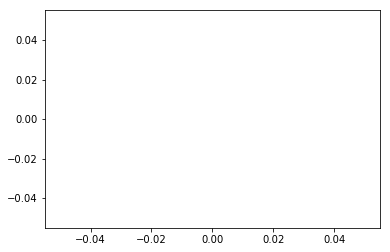

In [110]:
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t) 